In [1]:
from math import radians, cos, sin, asin, sqrt

import numpy as np
import pandas as pd
# import geopandas as gpd


#import matplotlib.pyplot as plt
import seaborn as sns

# from shapely.geometry.polygon import Polygon
# from shapely.geometry.multipolygon import MultiPolygon

pd.set_option("display.max_columns",None)
sns.set_theme(style="darkgrid",palette=sns.color_palette("Set2"))

# Data Preparation 

## asset



In [3]:
df_assets_raw=pd.read_csv("final asset data.csv")
df_assets_raw.head(1)

,InstName,pptyKey,pptyName,lat,long,reitStatus,Y2020,Y2019,Y2018,Y2017,Y2016,Y2015,Y2014,Y2013,Y2012,Y2011,Y2010,Y2009,Y2008,Y2007,Y2006,Y2005,Y2004,Y2003,Y2002,Y2001,Y2000,Y1999,Y1997,Y1998,Y1996,Y1995
0,Acadia Realty Trust,7283,Crescent Plaza,42.07879,-70.99062,Yes,3163.0,3418.0,3682.0,4017.0,4204.0,2947.0,3035.0,3333.0,3522.0,3675.0,3942.0,4210.0,4512.0,4773.0,4783.0,5050.0,5012.0,5225.0,5445.0,5640.0,5877.0,6084.0,6574.0,6324.0,6831.0,7075.0


In [4]:


df_assets_raw.isnull().sum().head()

InstName      0
pptyKey       0
pptyName      0
lat         797
long        797
dtype: int64

In [5]:
df_assets=df_assets_raw[~(df_assets_raw["lat"].isnull())].copy()

## asset value--book value

In [6]:
df_assets_values=df_assets_raw[['pptyKey',
                            'Y2020', 'Y2019', 'Y2018', 'Y2017', 'Y2016', 'Y2015', 'Y2014', 'Y2013', 'Y2012', 'Y2011', 
                            'Y2010','Y2009', 'Y2008', 'Y2007', 'Y2006', 'Y2005', 'Y2004', 'Y2003', 'Y2002', 'Y2001', 
                            'Y2000', 'Y1999', 'Y1997', 'Y1998', 'Y1996','Y1995']].copy()
df_assets_values=df_assets_values.set_index("pptyKey").stack().reset_index()
df_assets_values.columns=["pptyKey","year","value"]
df_assets_values["year"]=df_assets_values["year"].str[1:].astype(int)
df_assets_values.head()

,pptyKey,year,value
0,7283,2020,3163.0
1,7283,2019,3418.0
2,7283,2018,3682.0
3,7283,2017,4017.0
4,7283,2016,4204.0


## asset location

In [7]:
df_assets_location=df_assets_raw[['InstName', 'pptyKey', 'pptyName', 'lat', 'long', 'reitStatus']].copy()
df_assets_location.head()

,InstName,pptyKey,pptyName,lat,long,reitStatus
0,Acadia Realty Trust,7283,Crescent Plaza,42.07879,-70.99062,Yes
1,Acadia Realty Trust,7292,Mark Plaza,41.25680,-75.90829,Yes
2,Acadia Realty Trust,7297,New Loudon Center,42.75452,-73.75660,Yes
3,Acadia Realty Trust,7305,Plaza 422,40.34024,-76.39804,Yes
4,Acadia Realty Trust,21685,Route 6 Mall,41.55060,-75.22972,Yes


In [8]:
df_assets_location.shape

(53230, 6)

## hurricane landfall

In [9]:

df_hurricane=pd.read_csv("hurricane_landfall.csv")
df_hurricane.isnull().sum()

stormid                0
oceanbasin          7444
surfacewindspeed    1329
latitude               0
longitude              0
year                   0
month                  0
day                    0
hour                 469
name                   0
dtype: int64

In [10]:

df_hurricane["hour"]=df_hurricane["hour"].fillna(0)

df_hurricane["datetime"]=df_hurricane.apply(lambda row: 
                                            pd.to_datetime("{}-{}-{} {}:00:00".format(row["year"],row["month"],row["day"],row["hour"])),
                                            axis=1)
df_hurricane["uniqueID"]=df_hurricane.index
df_hurricane.head()

,stormid,oceanbasin,surfacewindspeed,latitude,longitude,year,month,day,hour,name,datetime,uniqueID
0,1995154N17276,NaN,25.0,17.4,-84.3,1995,6,2,0.0,ALLISON,1995-06-02 00:00:00,0
1,1995154N17276,NaN,25.0,17.4,-84.3,1995,6,2,6.0,ALLISON,1995-06-02 06:00:00,1
2,1995154N17276,NaN,25.0,17.4,-84.3,1995,6,2,12.0,ALLISON,1995-06-02 12:00:00,2
3,1995154N17276,NaN,25.0,17.4,-84.3,1995,6,2,18.0,ALLISON,1995-06-02 18:00:00,3
4,1995154N17276,NaN,25.0,17.4,-84.3,1995,6,3,0.0,ALLISON,1995-06-03 00:00:00,4


In [11]:
df_hurricane.shape

(7457, 12)

# Find affected properties

## Calculate Lat/Long

In [12]:

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956 # Radius of earth in miles. Use 3956 for miles,6371 for kilometers
    return c * r

In [13]:
%%time


def calc_dist_(long,lat,df_hurricane):
    df_hurricane_tmp=df_hurricane[["latitude","longitude"]].copy()
    dist_list=df_hurricane_tmp.apply(lambda row: haversine(row["longitude"],row["latitude"], long, lat),axis=1).to_list()
    return dist_list

sample_distance=calc_dist_(-84.3,17.4,df_hurricane)
print(len(sample_distance))
print(sample_distance[:5])

7457
[0.0, 0.0, 0.0, 0.0, 0.0]
CPU times: user 94.4 ms, sys: 3.58 ms, total: 98 ms
Wall time: 99.2 ms


In [14]:


from joblib import Parallel, delayed

def process_1group(dfgroup):
    dfgroup["distance_list2"]=dfgroup.apply(lambda row: calc_dist_(row["long"],row["lat"],df_hurricane),axis=1)
    return dfgroup

def apply_all_groups(df_assets_location,func):
    dfgroups=df_assets_location.groupby("groupid")
    ret_list=Parallel(n_jobs=4)(delayed(func)(group) for name,group in dfgroups)
    return pd.concat(ret_list)

In [15]:

df_assets_location["groupid"]=df_assets_location.index%4

In [16]:
%%time

df_assets_hurricane=apply_all_groups(df_assets_location,process_1group)
df_assets_hurricane.head()

Wall time: 52min 13s


,InstName,pptyKey,pptyName,lat,long,reitStatus,groupid,distance_list2
0,Acadia Realty Trust,7283,Crescent Plaza,42.07879,-70.99062,Yes,0,"[1876.0956517541658, 1876.0956517541658, 1876...."
4,Acadia Realty Trust,21685,Route 6 Mall,41.55060,-75.22972,Yes,0,"[1751.8266967490856, 1751.8266967490856, 1751...."
8,Acadia Realty Trust,32941,Elmwood Park Shopping Center,40.91877,-74.12371,Yes,0,"[1732.8724778931764, 1732.8724778931764, 1732...."
12,Acadia Realty Trust,32946,Bloomfield Town Square,42.60849,-83.29428,Yes,0,"[1741.5305297408427, 1741.5305297408427, 1741...."
16,Acadia Realty Trust,40976,Greenwich Avenue 239,41.02682,-73.62573,Yes,0,"[1750.211528290829, 1750.211528290829, 1750.21..."


In [17]:
df_assets_hurricane["distance_list"]=df_assets_hurricane["distance_list2"].apply(lambda x: np.argwhere(np.array(x)<50).flatten())
df_assets_hurricane.head()

,InstName,pptyKey,pptyName,lat,long,reitStatus,groupid,distance_list2,distance_list
0,Acadia Realty Trust,7283,Crescent Plaza,42.07879,-70.99062,Yes,0,"[1876.0956517541658, 1876.0956517541658, 1876....","[334, 2802, 3993, 4486, 5856]"
4,Acadia Realty Trust,21685,Route 6 Mall,41.55060,-75.22972,Yes,0,"[1751.8266967490856, 1751.8266967490856, 1751....","[7051, 7280]"
8,Acadia Realty Trust,32941,Elmwood Park Shopping Center,40.91877,-74.12371,Yes,0,"[1732.8724778931764, 1732.8724778931764, 1732....","[1211, 5208, 7252, 7253]"
12,Acadia Realty Trust,32946,Bloomfield Town Square,42.60849,-83.29428,Yes,0,"[1741.5305297408427, 1741.5305297408427, 1741....","[3086, 3191]"
16,Acadia Realty Trust,40976,Greenwich Avenue 239,41.02682,-73.62573,Yes,0,"[1750.211528290829, 1750.211528290829, 1750.21...","[1211, 7252, 7253]"


In [18]:
df_assets_hurricane_explode=df_assets_hurricane.explode(column="distance_list")
df_assets_hurricane_explode.head()

,InstName,pptyKey,pptyName,lat,long,reitStatus,groupid,distance_list2,distance_list
0,Acadia Realty Trust,7283,Crescent Plaza,42.07879,-70.99062,Yes,0,"[1876.0956517541658, 1876.0956517541658, 1876....",334
0,Acadia Realty Trust,7283,Crescent Plaza,42.07879,-70.99062,Yes,0,"[1876.0956517541658, 1876.0956517541658, 1876....",2802
0,Acadia Realty Trust,7283,Crescent Plaza,42.07879,-70.99062,Yes,0,"[1876.0956517541658, 1876.0956517541658, 1876....",3993
0,Acadia Realty Trust,7283,Crescent Plaza,42.07879,-70.99062,Yes,0,"[1876.0956517541658, 1876.0956517541658, 1876....",4486
0,Acadia Realty Trust,7283,Crescent Plaza,42.07879,-70.99062,Yes,0,"[1876.0956517541658, 1876.0956517541658, 1876....",5856


In [19]:
# save data

# df_assets_hurricane_explode.to_csv("df_assets_hurricane_explode.csv")

In [20]:
df_assets_hurricane_explode=df_assets_hurricane_explode[~(df_assets_hurricane_explode["distance_list"].isnull())].copy()
df_assets_hurricane_explode.head()

,InstName,pptyKey,pptyName,lat,long,reitStatus,groupid,distance_list2,distance_list
0,Acadia Realty Trust,7283,Crescent Plaza,42.07879,-70.99062,Yes,0,"[1876.0956517541658, 1876.0956517541658, 1876....",334
0,Acadia Realty Trust,7283,Crescent Plaza,42.07879,-70.99062,Yes,0,"[1876.0956517541658, 1876.0956517541658, 1876....",2802
0,Acadia Realty Trust,7283,Crescent Plaza,42.07879,-70.99062,Yes,0,"[1876.0956517541658, 1876.0956517541658, 1876....",3993
0,Acadia Realty Trust,7283,Crescent Plaza,42.07879,-70.99062,Yes,0,"[1876.0956517541658, 1876.0956517541658, 1876....",4486
0,Acadia Realty Trust,7283,Crescent Plaza,42.07879,-70.99062,Yes,0,"[1876.0956517541658, 1876.0956517541658, 1876....",5856


In [21]:
df_assets_hurricane_explode_merge=pd.merge(df_assets_hurricane_explode[['InstName', 'pptyKey', 'pptyName', 'lat', 'long','distance_list']],
                                     df_hurricane[['stormid', 'surfacewindspeed', 'latitude', 'longitude', 'year', 'name']],
                                     left_on="distance_list",right_index=True,how="inner")

df_assets_hurricane_explode_merge.head()

,InstName,pptyKey,pptyName,lat,long,distance_list,stormid,surfacewindspeed,latitude,longitude,year,name
0,Acadia Realty Trust,7283,Crescent Plaza,42.07879,-70.99062,334,1996187N10326,NaN,42.1,-71.9,1996,BERTHA
64,Acadia Realty Trust,291747,Rhode Island Mall,41.71997,-71.48171,334,1996187N10326,NaN,42.1,-71.9,1996,BERTHA
144,Agree Realty Corporation,184593,CVS-Mansfield,41.82668,-72.26683,334,1996187N10326,NaN,42.1,-71.9,1996,BERTHA
588,Agree Realty Corporation,360143,Springfield-MA,42.10965,-72.57276,334,1996187N10326,NaN,42.1,-71.9,1996,BERTHA
1312,"Alexandria Real Estate Equities, Inc.",34796,Charlestown Navy Yard,42.37834,-71.05263,334,1996187N10326,NaN,42.1,-71.9,1996,BERTHA


In [22]:
df_assets_infos=pd.merge(df_assets_raw[['InstName', 'pptyKey', 'pptyName', 'lat', 'long', 'reitStatus']],
         df_assets_values,
         left_on='pptyKey',right_on='pptyKey')


df_assets_infos=df_assets_infos[~(df_assets_infos["value"].isnull())].copy()


df_assets_infos=df_assets_infos[df_assets_infos["InstName"].isin(df_assets_hurricane_explode_merge["InstName"])].copy()
df_assets_infos.head()

,InstName,pptyKey,pptyName,lat,long,reitStatus,year,value
0,Acadia Realty Trust,7283,Crescent Plaza,42.07879,-70.99062,Yes,2020,3163.0
1,Acadia Realty Trust,7283,Crescent Plaza,42.07879,-70.99062,Yes,2019,3418.0
2,Acadia Realty Trust,7283,Crescent Plaza,42.07879,-70.99062,Yes,2018,3682.0
3,Acadia Realty Trust,7283,Crescent Plaza,42.07879,-70.99062,Yes,2017,4017.0
4,Acadia Realty Trust,7283,Crescent Plaza,42.07879,-70.99062,Yes,2016,4204.0


In [23]:
df_assets_infos.shape

(296489, 8)

In [24]:
df_assets_infos=pd.merge(df_assets_infos,
                         df_assets_hurricane_explode_merge[['pptyKey','stormid', 'surfacewindspeed', 'latitude', 'longitude', 'year', 'name']],
                        left_on=["pptyKey","year"],right_on=["pptyKey","year"],how="left")

df_assets_infos=df_assets_infos.sort_values(by=["stormid","year"])
df_assets_infos.head()

,InstName,pptyKey,pptyName,lat,long,reitStatus,year,value,stormid,surfacewindspeed,latitude,longitude,name
240270,SITE Centers Corp.,5299,University Centre,34.23613,-77.87650,Yes,1995,24341.0,1995154N17276,NaN,34.5,-78.1,ALLISON
41023,"CBL & Associates Properties, Inc.",4757,Post Oak Mall,30.62456,-96.30314,Yes,1995,45567.0,1995210N26273,NaN,30.5,-96.5,DEAN
41024,"CBL & Associates Properties, Inc.",4757,Post Oak Mall,30.62456,-96.30314,Yes,1995,45567.0,1995210N26273,NaN,30.0,-96.0,DEAN
171633,"Mid-America Apartment Communities, Inc.",7152,Cypresswood Court,30.03906,-95.34010,Yes,1995,5926.0,1995210N26273,NaN,29.5,-95.5,DEAN
171634,"Mid-America Apartment Communities, Inc.",7152,Cypresswood Court,30.03906,-95.34010,Yes,1995,5926.0,1995210N26273,NaN,30.0,-96.0,DEAN


In [25]:
df_assets_infos.to_csv("df_assets_infos.csv")

# Statistic

## Hurricane hit times by year

In [26]:
df_company_yearly_storm_num=df_assets_infos.pivot_table(index="InstName",columns="year",values="stormid",aggfunc="nunique")

df_company_yearly_storm_num["total_storm_num"]=df_company_yearly_storm_num.sum(axis=1)
df_company_yearly_storm_num=df_company_yearly_storm_num.sort_values(by="total_storm_num",ascending=False)

df_company_yearly_storm_num.head()

year,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,total_storm_num
InstName,,,,,,,,,,,,,,,,,,,,,,,,,,,
"National Retail Properties, Inc.",2.0,1.0,1.0,4.0,4.0,4.0,3.0,6.0,5.0,5.0,7.0,2.0,7.0,6.0,2.0,4.0,3.0,4.0,1.0,1.0,2.0,5.0,7.0,4.0,4.0,11.0,105.0
"Life Storage, Inc.",3.0,2.0,1.0,6.0,4.0,4.0,2.0,6.0,5.0,8.0,7.0,3.0,5.0,5.0,2.0,3.0,2.0,4.0,1.0,0.0,2.0,5.0,6.0,4.0,4.0,10.0,104.0
"Simon Property Group, Inc.",0.0,2.0,1.0,2.0,2.0,3.0,3.0,3.0,3.0,7.0,7.0,2.0,6.0,6.0,2.0,4.0,2.0,4.0,1.0,0.0,2.0,1.0,6.0,4.0,4.0,10.0,87.0
"LTC Properties, Inc.",2.0,1.0,1.0,2.0,3.0,2.0,3.0,4.0,4.0,6.0,4.0,2.0,4.0,6.0,2.0,3.0,1.0,3.0,1.0,0.0,2.0,5.0,6.0,3.0,4.0,9.0,83.0
Kimco Realty Corporation,2.0,2.0,1.0,3.0,3.0,2.0,2.0,2.0,4.0,7.0,5.0,2.0,4.0,6.0,0.0,3.0,2.0,3.0,1.0,1.0,2.0,5.0,5.0,4.0,3.0,7.0,81.0


In [27]:
df_company_yearly_storm_num.shape

(224, 27)

Text(0.5, 1.0, 'Yearly Storm Encounter Number(top30 company)')

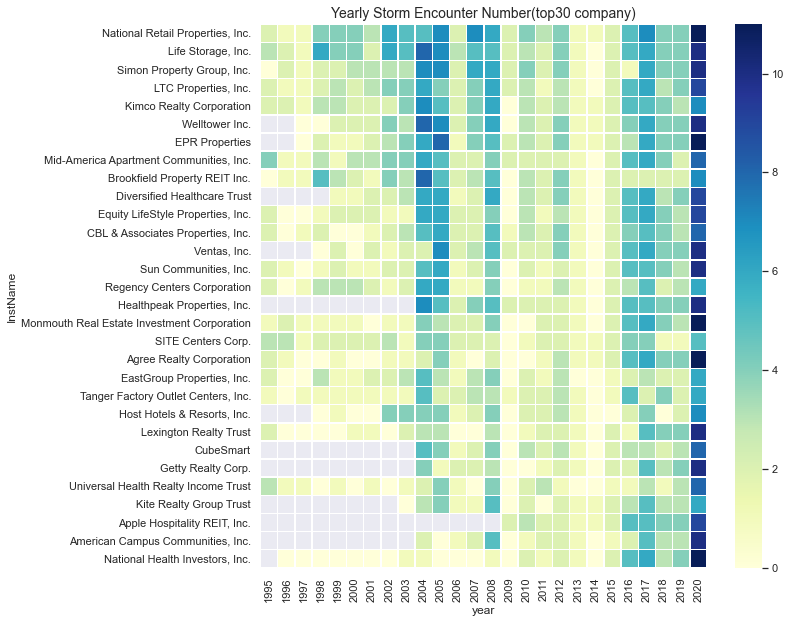

In [28]:

plt.figure(figsize=(10,10))

sns.heatmap(df_company_yearly_storm_num.iloc[:30,:-1], cmap="YlGnBu",linewidths=.5)
plt.title("Yearly Storm Encounter Number(top30 company)",fontsize=14)

## Asset value increase rate vs number of hurricanes encountered

In [29]:


df_assets_infos_nodup=df_assets_infos[["InstName","pptyKey","pptyName","lat","long","year","value"]].drop_duplicates()
df_assets_infos_nodup=df_assets_infos_nodup.groupby(["InstName","year"])["value"].sum().reset_index()

df_assets_infos_nodup=df_assets_infos_nodup.sort_values(by=["InstName","year"])
df_assets_infos_nodup["asset_increase"]=df_assets_infos_nodup.groupby("InstName")["value"].pct_change()
df_assets_infos_nodup.head(10)

,InstName,year,value,asset_increase
0,Acadia Realty Trust,1995,35468.0,NaN
1,Acadia Realty Trust,1996,34483.0,-0.027772
2,Acadia Realty Trust,1997,32928.0,-0.045095
3,Acadia Realty Trust,1998,166455.0,4.055120
4,Acadia Realty Trust,1999,207938.0,0.249215
5,Acadia Realty Trust,2000,193007.0,-0.071805
6,Acadia Realty Trust,2001,191294.0,-0.008875
7,Acadia Realty Trust,2002,199807.0,0.044502
8,Acadia Realty Trust,2003,202257.0,0.012262
9,Acadia Realty Trust,2004,199073.0,-0.015742


In [30]:


df_storm_maxspeed=df_assets_infos.groupby(["InstName","year","stormid"])["surfacewindspeed"].max().reset_index()
df_storm_yearly_info=df_storm_maxspeed.groupby(["InstName","year"]).agg({"stormid":"nunique","surfacewindspeed":"sum"}).reset_index()
df_storm_yearly_info.head()

,InstName,year,stormid,surfacewindspeed
0,Acadia Realty Trust,1996,1,0.0
1,Acadia Realty Trust,1999,2,60.0
2,Acadia Realty Trust,2000,1,25.0
3,Acadia Realty Trust,2004,2,60.0
4,Acadia Realty Trust,2005,3,0.0


In [31]:


df_assets_storm_merge=pd.merge(df_assets_infos_nodup,df_storm_yearly_info,on=["InstName","year"])
df_assets_storm_merge=df_assets_storm_merge[(df_assets_storm_merge["asset_increase"]<=1)&(df_assets_storm_merge["asset_increase"]>=-1)]
df_assets_storm_merge.head()

,InstName,year,value,asset_increase,stormid,surfacewindspeed
0,Acadia Realty Trust,1996,34483.0,-0.027772,1,0.0
1,Acadia Realty Trust,1999,207938.0,0.249215,2,60.0
2,Acadia Realty Trust,2000,193007.0,-0.071805,1,25.0
3,Acadia Realty Trust,2004,199073.0,-0.015742,2,60.0
4,Acadia Realty Trust,2005,232312.0,0.166969,3,0.0


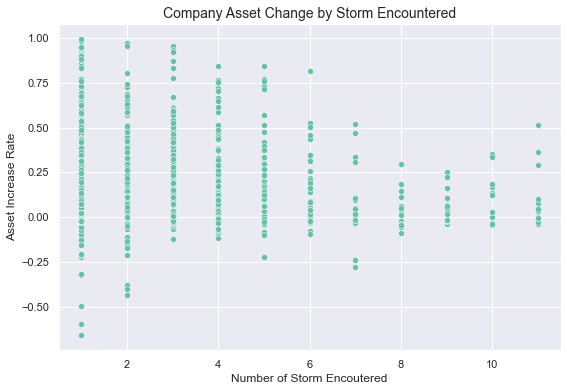

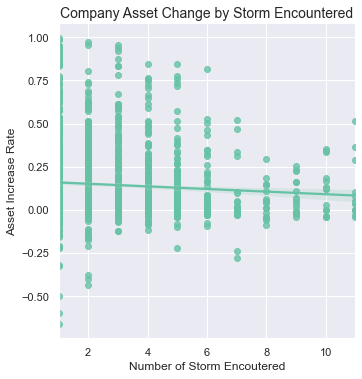

In [32]:


plt.figure(figsize=(9,6))
sns.scatterplot(y="asset_increase",x="stormid",data=df_assets_storm_merge)
# plt.ylim(-1,5)
plt.xlabel("Number of Storm Encoutered",fontsize=12)
plt.ylabel("Asset Increase Rate",fontsize=12)
plt.title("Company Asset Change by Storm Encountered",fontsize=14)
plt.show()


sns.lmplot(y="asset_increase",x="stormid",data=df_assets_storm_merge)
# plt.ylim(-1,5)
plt.xlabel("Number of Storm Encoutered",fontsize=12)
plt.ylabel("Asset Increase Rate",fontsize=12)
plt.title("Company Asset Change by Storm Encountered",fontsize=14)
plt.show()

<AxesSubplot:xlabel='stormid'>

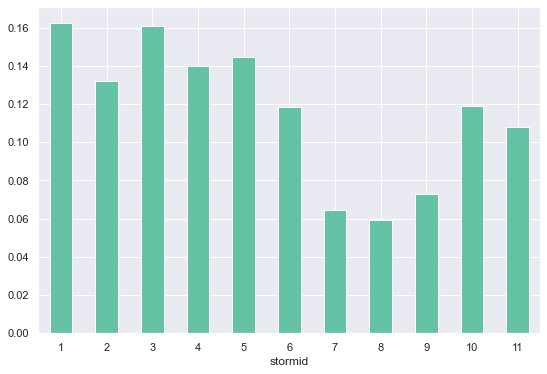

In [33]:


df_assets_storm_merge.groupby("stormid")["asset_increase"].mean().plot(kind="bar",figsize=(9,6),rot=0)

## Asset value increase rate  vs wind speed

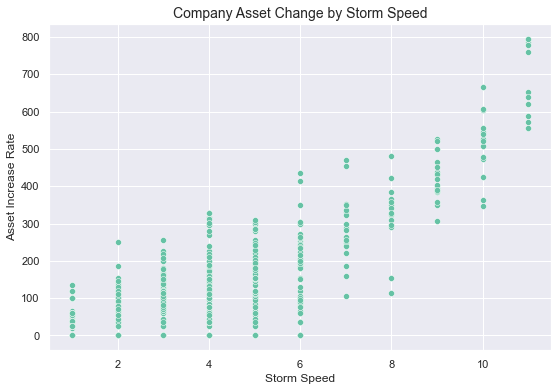

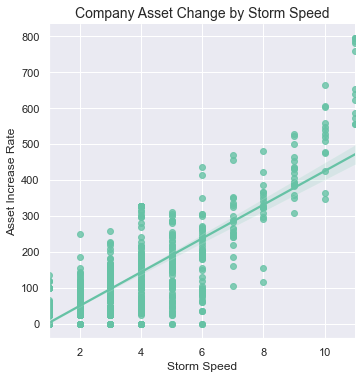

In [34]:


plt.figure(figsize=(9,6))
sns.scatterplot(y="surfacewindspeed",x="stormid",data=df_assets_storm_merge)
# plt.ylim(-1,5)
plt.xlabel("Storm Speed",fontsize=12)
plt.ylabel("Asset Increase Rate",fontsize=12)
plt.title("Company Asset Change by Storm Speed",fontsize=14)
plt.show()


sns.lmplot(y="surfacewindspeed",x="stormid",data=df_assets_storm_merge)
# plt.ylim(-1,5)
plt.xlabel("Storm Speed",fontsize=12)
plt.ylabel("Asset Increase Rate",fontsize=12)
plt.title("Company Asset Change by Storm Speed",fontsize=14)
plt.show()

# data visualization

In [35]:


df_company_sample=df_company_yearly_storm_num.index[:5].to_list()
df_company_sample

['National Retail Properties, Inc.',
 'Life Storage, Inc.',
 'Simon Property Group, Inc.',
 'LTC Properties, Inc.',
 'Kimco Realty Corporation']

In [36]:


def plot_company_assets(df_assets_infos,company_name="National Retail Properties, Inc."):
    
     #--------------------------------plot asset
    # select company data
    df_assets_infos_1com=df_assets_infos[df_assets_infos["InstName"]==company_name].copy()
    df_assets_infos_1com_loc=df_assets_infos_1com.groupby(["pptyKey","lat","long"])["value_mms"].max().reset_index()

    plt.figure(figsize=(20,10))
    map=Basemap(projection='aea',lat_0=37.5,lon_0=-95,llcrnrlat=20,urcrnrlat=50,llcrnrlon=-120,urcrnrlon=-60)
    map.fillcontinents(color='white',lake_color='powderblue')
    map.drawmapboundary(fill_color='powderblue')
    map.drawcountries(linewidth=0.5, linestyle='solid', color='k')
    map.drawstates(linewidth=0.1, linestyle='--', color='k')
    
    x,y=map(df_assets_infos_1com_loc["long"].values,df_assets_infos_1com_loc["lat"].values)
    map.scatter(x,y,s=df_assets_infos_1com_loc["value_mms"],c="red",label="Assets")
    
    #--------------------------------plot storm
    df_assets_infos_1com_storm=df_assets_infos_1com[["stormid","latitude","longitude"]].drop_duplicates()
    x,y=map(df_assets_infos_1com_storm["longitude"].values,df_assets_infos_1com_storm["latitude"].values)
    map.scatter(x,y,s=20,c="white",edgecolors="blue",alpha=0.5,label="Hurricane")    

    plt.title("Assets Location vs Storm Location: {}".format(company_name),fontsize=14)
    plt.xlabel("Longitude",fontsize=12)
    plt.ylabel("Latitude",fontsize=12)
    plt.legend(loc="upper right",fontsize=12)
    plt.show()

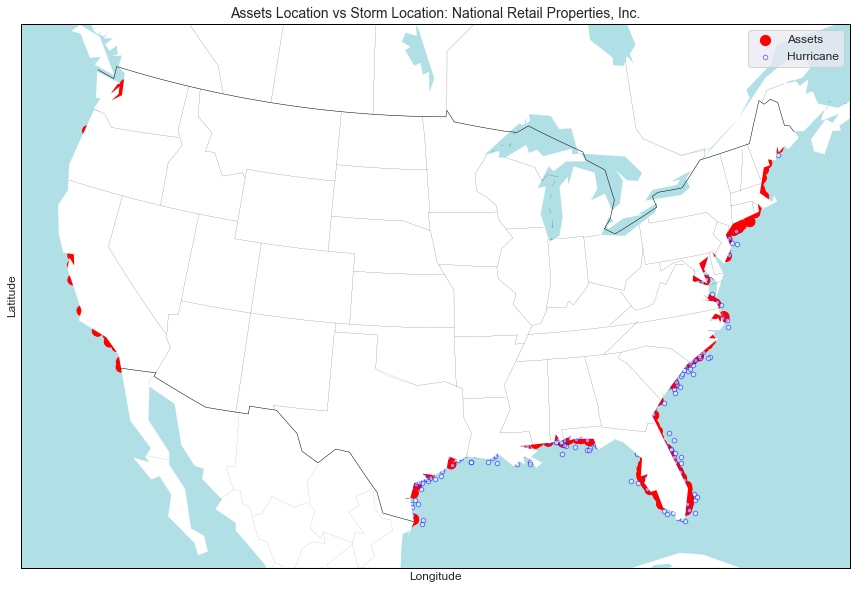

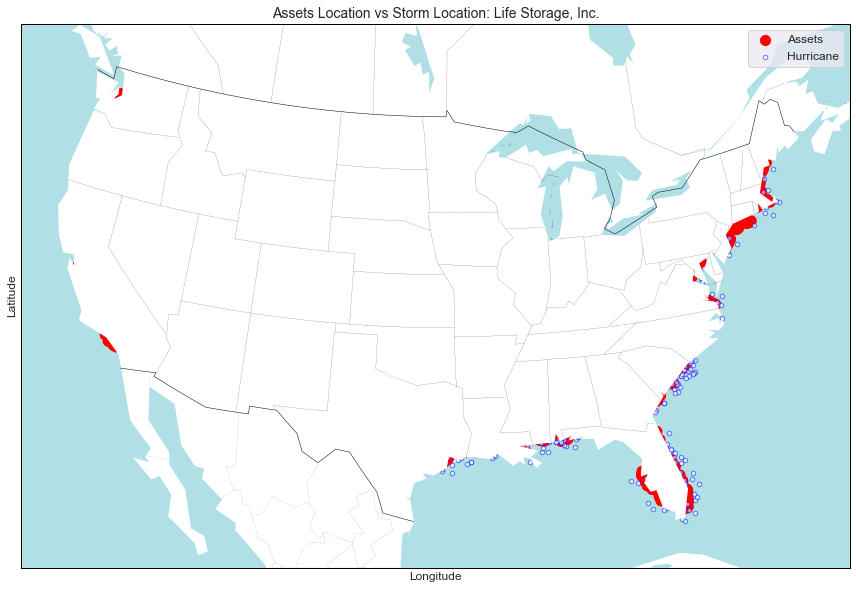

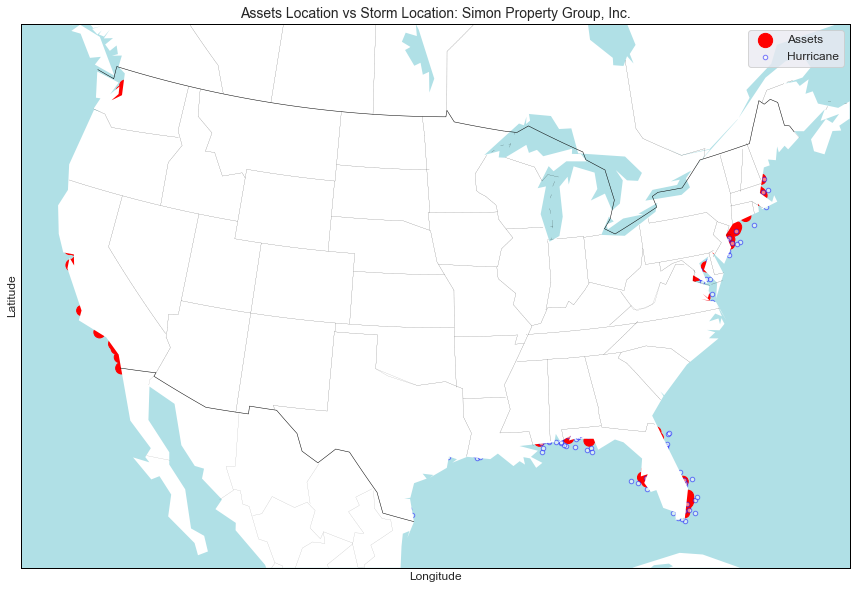

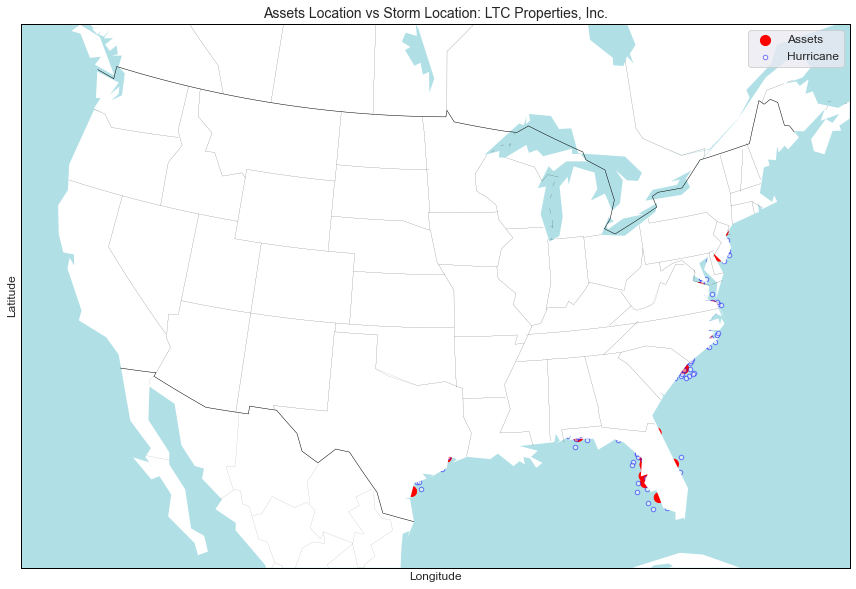

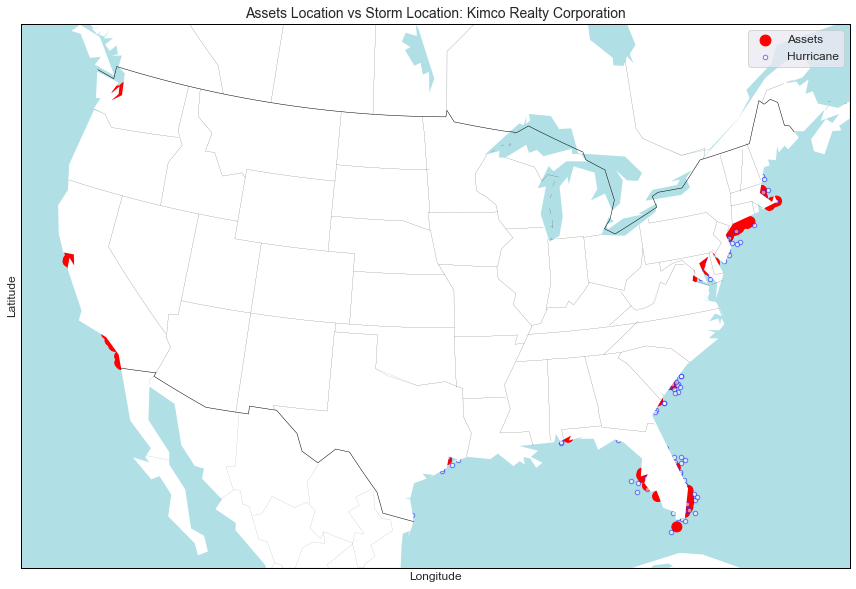

In [37]:


from sklearn.preprocessing import MinMaxScaler
df_assets_infos["value_mms"]=MinMaxScaler((100,1000)).fit_transform(df_assets_infos[["value"]])

for company in df_company_sample:
    plot_company_assets(df_assets_infos,company_name=company)
    print(" ")

In [38]:

def plot_company_yearly_asset(df_assets_infos,company_name="National Retail Properties, Inc."):
    df_assets_infos_1com=df_assets_infos[df_assets_infos["InstName"]==company_name].copy()
    df_assets_infos_1com_year=df_assets_infos_1com.groupby(["year"])["value"].sum().reset_index()

    df_nstorm_year=df_assets_infos.groupby("year")["name"].nunique().reset_index()
    df_assets_infos_1com_year=pd.merge(df_assets_infos_1com_year,df_nstorm_year,on="year",how="left")

    plt.figure(figsize=(9,6))
    sns.lineplot(x="year",y="value",marker="o",data=df_assets_infos_1com_year)

    for idx,row in df_assets_infos_1com_year.iterrows():
        if row["name"]>0:
            plt.text(row["year"],row["value"]*1.1,"S",ha="center",va="bottom",fontsize=10,color="red")

    plt.ylim(0,df_assets_infos_1com_year["value"].max()*1.2)

    plt.title("Total Assets Value by Year: {}".format(company_name),fontsize=14)
    plt.xlabel("Year",fontsize=12)
    plt.ylabel("Total Assets Values",fontsize=12)
    plt.show()

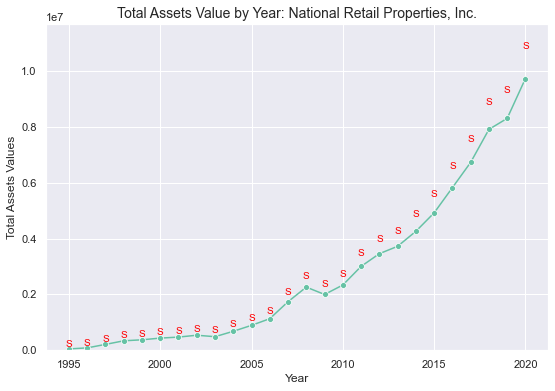

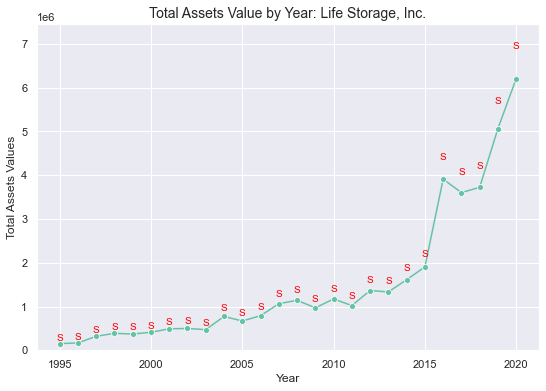

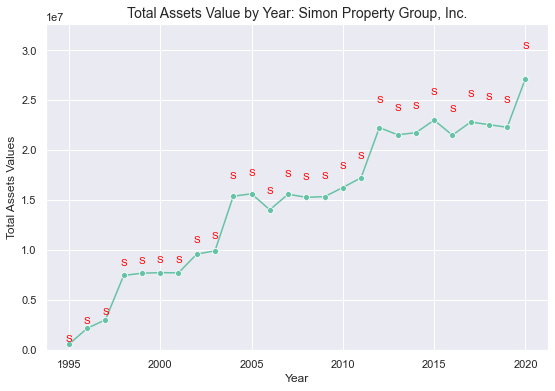

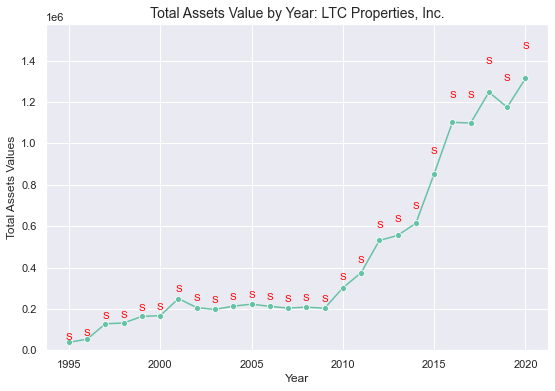

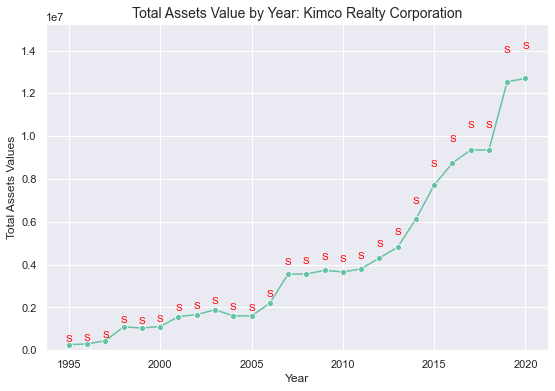

In [39]:


for company in df_company_sample:
    plot_company_yearly_asset(df_assets_infos,company_name=company)
    print(" ")

# Asset value -- writedown value

In [15]:
df_assets_down=pd.read_csv("writedown.csv")
df_assets_down.head(6)

,INSTN_NAME,PPTY_KEY,PPTY_NAME,ELECTED_REIT_STATUS,2020Y,2019Y,2018Y,2017Y,2016Y,2015Y,2014Y,2013Y,2012Y,2011Y,2010Y,2009Y,2008Y,2007Y,2006Y,2005Y,2004Y,2003Y,2002Y,2001Y,2000Y,1999Y,1998Y,1997Y,1996Y,1995Y
0,Acadia Realty Trust,7283,Crescent Plaza,Yes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Acadia Realty Trust,7292,Mark Plaza,Yes,0.0,0.0,0.0,0.0,0.0,0.0,872.0,872.0,872.0,872.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Acadia Realty Trust,7297,New Loudon Center,Yes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Acadia Realty Trust,7305,Plaza 422,Yes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Acadia Realty Trust,21685,Route 6 Mall,Yes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Acadia Realty Trust,32938,Crossroads Shopping Center,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df_assets_down_values=df_assets_down[['PPTY_KEY',
                             '2020Y',
       '2019Y', '2018Y', '2017Y', '2016Y', '2015Y', '2014Y', '2013Y', '2012Y',
       '2011Y', '2010Y', '2009Y', '2008Y', '2007Y', '2006Y', '2005Y', '2004Y',
       '2003Y', '2002Y', '2001Y', '2000Y', '1999Y', '1998Y', '1997Y', '1996Y',
       '1995Y']].copy()
df_assets_down_values=df_assets_down_values.set_index("PPTY_KEY").stack().reset_index()
df_assets_down_values.columns=["pptyKey","year","value"]
df_assets_down_values["year"]=df_assets_down_values["year"].str[:-1].astype(int)
df_assets_down_values.head()

,pptyKey,year,value
0,7283,2020,0.0
1,7283,2019,0.0
2,7283,2018,0.0
3,7283,2017,0.0
4,7283,2016,0.0


In [17]:
df_assets_down_location=df_assets_down[['INSTN_NAME', 'PPTY_KEY', 'PPTY_NAME']].copy()
df_assets_down_location.columns=['InstName', 'pptyKey', 'pptyName']
df_assets_down_location.head()

,InstName,pptyKey,pptyName
0,Acadia Realty Trust,7283,Crescent Plaza
1,Acadia Realty Trust,7292,Mark Plaza
2,Acadia Realty Trust,7297,New Loudon Center
3,Acadia Realty Trust,7305,Plaza 422
4,Acadia Realty Trust,21685,Route 6 Mall


In [18]:
df_assets_down=pd.merge(df_assets_down_location,df_assets_down_values,on="pptyKey")
df_assets_down.head()

,InstName,pptyKey,pptyName,year,value
0,Acadia Realty Trust,7283,Crescent Plaza,2020,0.0
1,Acadia Realty Trust,7283,Crescent Plaza,2019,0.0
2,Acadia Realty Trust,7283,Crescent Plaza,2018,0.0
3,Acadia Realty Trust,7283,Crescent Plaza,2017,0.0
4,Acadia Realty Trust,7283,Crescent Plaza,2016,0.0


In [19]:

df_company_asset_down=df_assets_down.groupby(["InstName","year"])["value"].sum().reset_index()

df_company_asset_down.columns=["InstName","year","writedown_value"]


df_company_asset_down=df_company_asset_down.sort_values(by=["InstName","year"])
df_company_asset_down.head()

,InstName,year,writedown_value
0,Acadia Realty Trust,1995,0.0
1,Acadia Realty Trust,1996,0.0
2,Acadia Realty Trust,1997,0.0
3,Acadia Realty Trust,1998,0.0
4,Acadia Realty Trust,1999,0.0


# Affected companies

In [20]:
df_assets_infos=pd.read_csv("df_assets_infos.csv",index_col=[0],low_memory=False)
df_assets_infos.head()

,InstName,pptyKey,pptyName,lat,long,reitStatus,year,value,stormid,surfacewindspeed,latitude,longitude,name
240270,SITE Centers Corp.,5299,University Centre,34.23613,-77.87650,Yes,1995,24341,1995154N17276,NaN,34.5,-78.1,ALLISON
41023,"CBL & Associates Properties, Inc.",4757,Post Oak Mall,30.62456,-96.30314,Yes,1995,45567,1995210N26273,NaN,30.5,-96.5,DEAN
41024,"CBL & Associates Properties, Inc.",4757,Post Oak Mall,30.62456,-96.30314,Yes,1995,45567,1995210N26273,NaN,30.0,-96.0,DEAN
171633,"Mid-America Apartment Communities, Inc.",7152,Cypresswood Court,30.03906,-95.34010,Yes,1995,5926,1995210N26273,NaN,29.5,-95.5,DEAN
171634,"Mid-America Apartment Communities, Inc.",7152,Cypresswood Court,30.03906,-95.34010,Yes,1995,5926,1995210N26273,NaN,30.0,-96.0,DEAN


In [21]:
df_assets_infos["has_storm"]=df_assets_infos["stormid"].map(lambda x: 1 if pd.isnull(x) else 0)
df_assets_infos_unique=df_assets_infos[["InstName","pptyKey","year","value","has_storm"]].drop_duplicates()

df_company_asset=df_assets_infos_unique.groupby(["InstName","year"])['value'].sum().reset_index()
df_company_asset.columns=["InstName","year","asset_value"]
df_company_asset.head()

,InstName,year,asset_value
0,Acadia Realty Trust,1995,35468
1,Acadia Realty Trust,1996,34483
2,Acadia Realty Trust,1997,32928
3,Acadia Realty Trust,1998,166455
4,Acadia Realty Trust,1999,207938


In [22]:
df_company_storm=df_assets_infos.groupby(["InstName","year"]).agg({"stormid":["nunique","count"],
                                                 "surfacewindspeed":"max"}).reset_index().fillna(0)

df_company_storm.columns=["InstName","year","number_of_storm","storm_experience_hour","max_storm_speed"]
df_company_storm.head()

,InstName,year,number_of_storm,storm_experience_hour,max_storm_speed
0,Acadia Realty Trust,1995,0,0,0.0
1,Acadia Realty Trust,1996,1,1,0.0
2,Acadia Realty Trust,1997,0,0,0.0
3,Acadia Realty Trust,1998,0,0,0.0
4,Acadia Realty Trust,1999,2,8,60.0


In [23]:
df_company_asset_storm=pd.merge(df_company_asset,df_company_storm,on=["InstName","year"])
df_company_asset_storm.head()

,InstName,year,asset_value,number_of_storm,storm_experience_hour,max_storm_speed
0,Acadia Realty Trust,1995,35468,0,0,0.0
1,Acadia Realty Trust,1996,34483,1,1,0.0
2,Acadia Realty Trust,1997,32928,0,0,0.0
3,Acadia Realty Trust,1998,166455,0,0,0.0
4,Acadia Realty Trust,1999,207938,2,8,60.0


In [25]:
df_assets_infos=pd.read_csv("df_assets_infos.csv",low_memory=False)
df_assets_down=pd.read_csv("writedown.csv")

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
df_assets_down_values=df_assets_down[['PPTY_KEY',
                             '2020Y',
       '2019Y', '2018Y', '2017Y', '2016Y', '2015Y', '2014Y', '2013Y', '2012Y',
       '2011Y', '2010Y', '2009Y', '2008Y', '2007Y', '2006Y', '2005Y', '2004Y',
       '2003Y', '2002Y', '2001Y', '2000Y', '1999Y', '1998Y', '1997Y', '1996Y',
       '1995Y']].copy()
df_assets_down_values=df_assets_down_values.set_index("PPTY_KEY").stack().reset_index()
df_assets_down_values.columns=["pptyKey","year","value"]
df_assets_down_values["year"]=df_assets_down_values["year"].str[:-1].astype(int)

df_assets_down_location=df_assets_down[['INSTN_NAME', 'PPTY_KEY', 'PPTY_NAME']].copy()
df_assets_down_location.columns=['InstName', 'pptyKey', 'pptyName']
df_assets_down_location.head()

df_assets_down=pd.merge(df_assets_down_location,df_assets_down_values,on="pptyKey")
df_assets_down.head()

df_company_asset_down=df_assets_down.groupby(["InstName","year"])["value"].sum().reset_index()

df_company_asset_down.columns=["InstName","year","writedown_value"]


df_company_asset_down=df_company_asset_down.sort_values(by=["InstName","year"])
df_company_asset_down.head()

,InstName,year,writedown_value
0,Acadia Realty Trust,1995,0.0
1,Acadia Realty Trust,1996,0.0
2,Acadia Realty Trust,1997,0.0
3,Acadia Realty Trust,1998,0.0
4,Acadia Realty Trust,1999,0.0


In [32]:
def plot_company_yearly_asset(df_assets_infos,df_company_asset_down,company_name="National Retail Properties, Inc."):
    df_company_asset_down_1com=df_company_asset_down[df_company_asset_down["InstName"]==company_name].copy()
    df_company_asset_down_1com_year=df_company_asset_down_1com.groupby(["year"])["writedown_value"].sum().reset_index()
    #display(df_company_asset_down_1com_year)
    
    df_assets_infos_1com=df_assets_infos[df_assets_infos["InstName"]==company_name].copy()
   
    #display(df_assets_infos_1com)
    
    df_assets_infos_1com_year=df_assets_infos_1com.groupby(["year"])["value"].sum().reset_index()

    df_nstorm_year=df_assets_infos.groupby("year")["name"].nunique().reset_index()
    df_assets_infos_1com_year=pd.merge(df_assets_infos_1com_year,df_nstorm_year,on="year",how="left")
    
    df_assets_infos_1com_year=pd.merge(df_assets_infos_1com_year,df_company_asset_down_1com_year,on="year",how="left")

    if df_assets_infos_1com_year.shape[0]==0:
        return
    #display(df_assets_infos_1com_year)
    
    plt.figure(figsize=(9,6))
    sns.lineplot(x="year",y="writedown_value",marker="o",linewidth=3,markersize=10,data=df_assets_infos_1com_year)

    for idx,row in df_assets_infos_1com_year.iterrows():
        if row["name"]>0:
            plt.text(row["year"],row["writedown_value"]*1.1,'S',ha="center",va="bottom",fontsize=10,color="red")

    plt.ylim(0,df_assets_infos_1com_year["writedown_value"].max()*1.2)

    plt.title("Total Write Down Value by Year: {}".format(company_name),fontsize=14)
    plt.xlabel("Year",fontsize=12)
    plt.ylabel("Total Write Down Value",fontsize=12)
    plt.show()

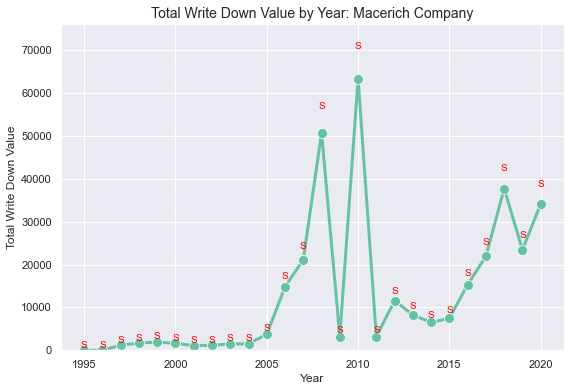

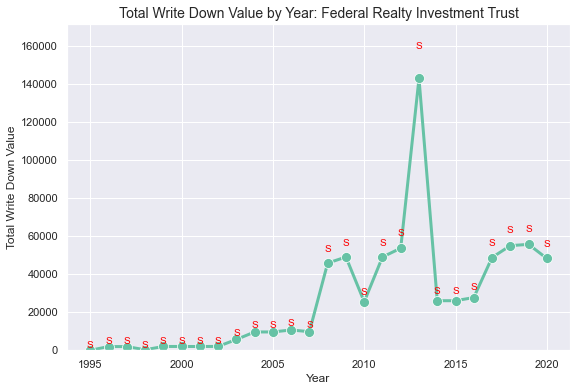

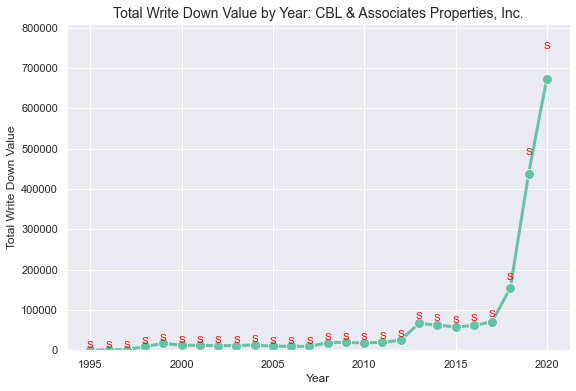

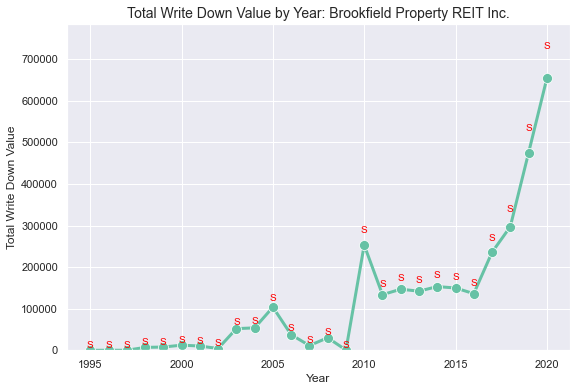

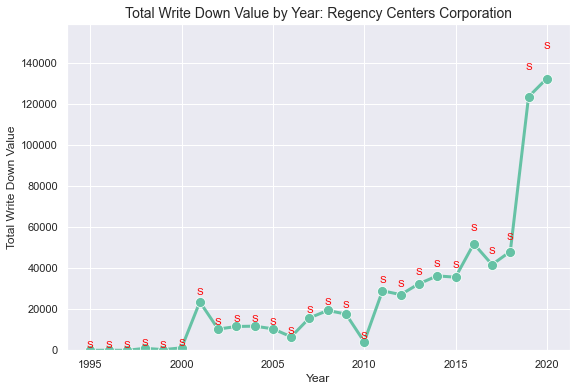

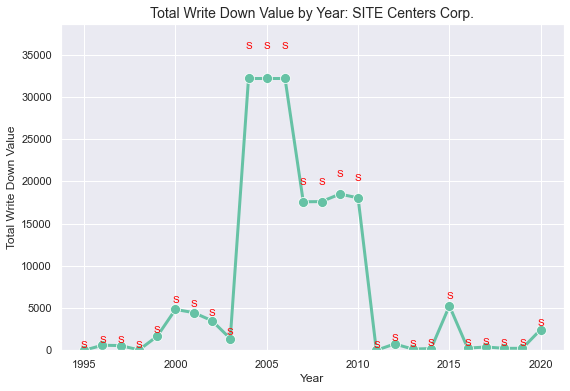

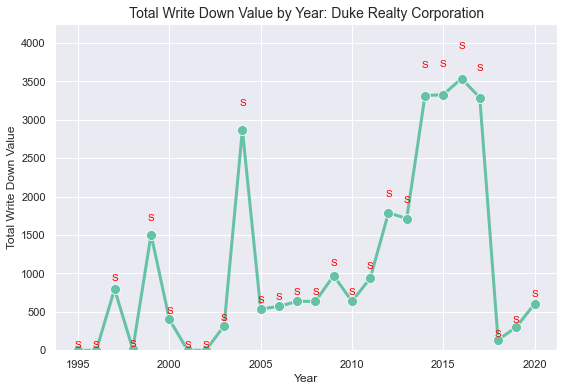

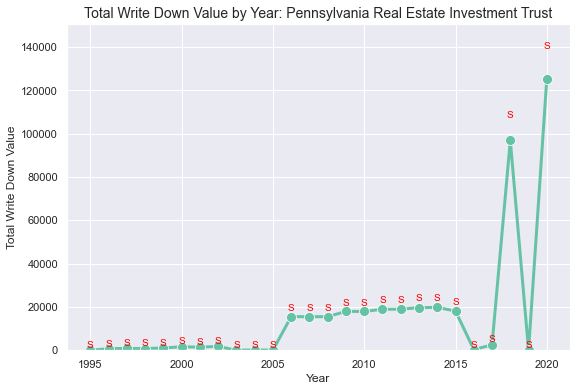

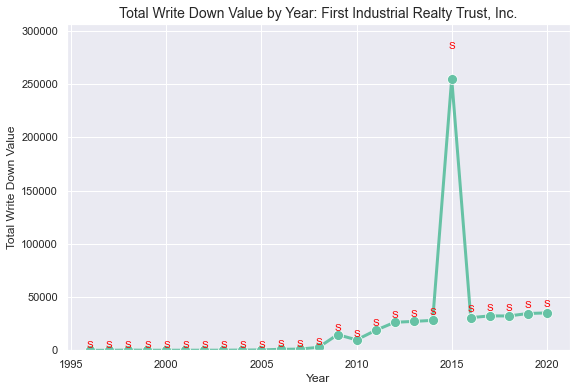

In [33]:
df_company_sample=df_company_asset_down[
    df_company_asset_down["writedown_value"]>0].groupby("InstName").size().sort_values(ascending=False).index[:10]
#df_company_sample=['National Retail Properties, Inc.']
for company in df_company_sample[:10]:
    plot_company_yearly_asset(df_assets_infos,df_company_asset_down,company_name=company)

# linear model

In [35]:
df_inflation=pd.read_csv("inflation rate.csv")
df_inflation=df_inflation[["year","Ave"]]
df_inflation.columns=["year","inflation_rate"]
df_inflation.head()

,year,inflation_rate
0,2021,NaN
1,2020,1.2
2,2019,1.8
3,2018,2.4
4,2017,2.1


In [36]:
df_company_asset_down=pd.merge(df_company_asset_down,df_inflation,on=["year"])
df_company_asset_down.head()

,InstName,year,writedown_value,inflation_rate
0,Acadia Realty Trust,1995,0.0,2.17
1,Agree Realty Corporation,1995,0.0,2.17
2,"Alexander's, Inc.",1995,0.0,2.17
3,Apartment Income REIT Corp.,1995,0.0,2.17
4,"AvalonBay Communities, Inc.",1995,810.0,2.17


In [37]:
df_company_asset_down_model=pd.merge(df_company_asset_down,df_company_asset_storm,on=["InstName","year"])

df_company_asset_down_model["writedown_pct"]=df_company_asset_down_model["writedown_value"]/df_company_asset_down_model["asset_value"]


df_company_asset_down_model.head()

,InstName,year,writedown_value,inflation_rate,asset_value,number_of_storm,storm_experience_hour,max_storm_speed,writedown_pct
0,Acadia Realty Trust,1995,0.0,2.17,35468,0,0,0.0,0.000000
1,Agree Realty Corporation,1995,0.0,2.17,12500,2,2,0.0,0.000000
2,"Alexander's, Inc.",1995,0.0,2.17,45094,0,0,0.0,0.000000
3,Apartment Income REIT Corp.,1995,0.0,2.17,18935,0,0,0.0,0.000000
4,"AvalonBay Communities, Inc.",1995,810.0,2.17,167279,0,0,0.0,0.004842


In [38]:
df_company_asset_down_model=df_company_asset_down_model[df_company_asset_down_model["number_of_storm"]>0]

df_company_asset_down_model=df_company_asset_down_model[df_company_asset_down_model["writedown_value"]>0]

df_company_asset_down_model=df_company_asset_down_model[df_company_asset_down_model["storm_experience_hour"]<200]

df_company_asset_down_model["writedown_pct"]=np.log(df_company_asset_down_model["writedown_pct"])
df_company_asset_down_model["writedown_value"]=np.log(df_company_asset_down_model["writedown_value"])
df_company_asset_down_model.shape

(989, 9)

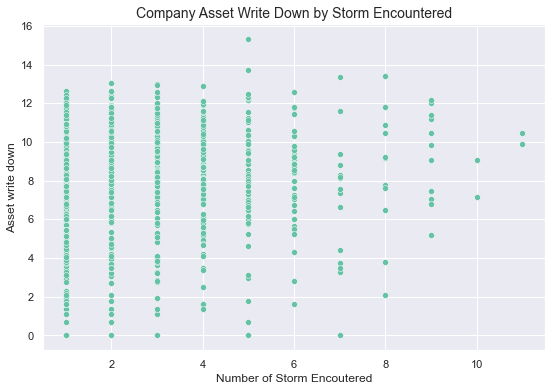

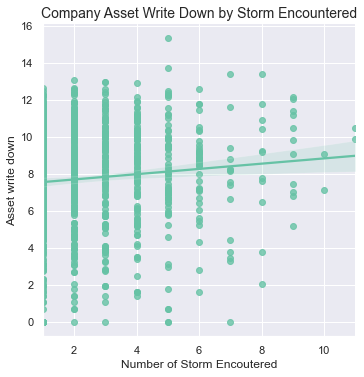

In [39]:
plt.figure(figsize=(9,6))
sns.scatterplot(y="writedown_value",x="number_of_storm",data=df_company_asset_down_model)
# plt.ylim(-1,5)
plt.xlabel("Number of Storm Encoutered",fontsize=12)
plt.ylabel("Asset write down",fontsize=12)
plt.title("Company Asset Write Down by Storm Encountered",fontsize=14)
plt.show()


sns.lmplot(y="writedown_value",x="number_of_storm",data=df_company_asset_down_model)
# plt.ylim(-1,5)
plt.xlabel("Number of Storm Encoutered",fontsize=12)
plt.ylabel("Asset write down",fontsize=12)
plt.title("Company Asset Write Down by Storm Encountered",fontsize=14)
plt.show()

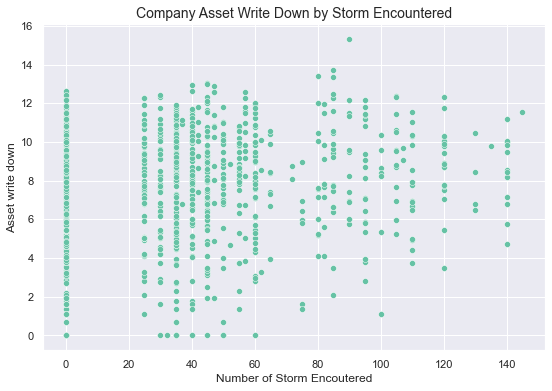

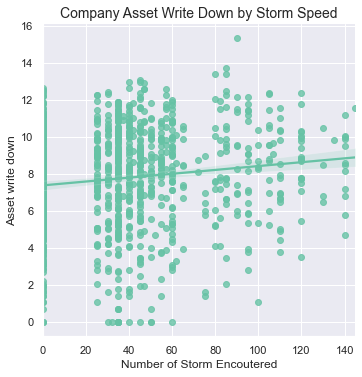

In [40]:
plt.figure(figsize=(9,6))
sns.scatterplot(y="writedown_value",x="max_storm_speed",data=df_company_asset_down_model)
# plt.ylim(-1,5)
plt.xlabel("Number of Storm Encoutered",fontsize=12)
plt.ylabel("Asset write down",fontsize=12)
plt.title("Company Asset Write Down by Storm Encountered",fontsize=14)
plt.show()


sns.lmplot(y="writedown_value",x="max_storm_speed",data=df_company_asset_down_model)
# plt.ylim(-1,5)
plt.xlabel("Number of Storm Encoutered",fontsize=12)
plt.ylabel("Asset write down",fontsize=12)
plt.title("Company Asset Write Down by Storm Speed",fontsize=14)
plt.show()

,inflation_rate,number_of_storm,storm_experience_hour,max_storm_speed,writedown_pct,writedown_value
inflation_rate,1.000000,-0.038789,-0.044010,0.010815,-0.032869,-0.106005
number_of_storm,-0.038789,1.000000,0.555873,0.582214,-0.002225,0.093660
storm_experience_hour,-0.044010,0.555873,1.000000,0.419370,-0.008795,0.112545
max_storm_speed,0.010815,0.582214,0.419370,1.000000,0.014659,0.127228
writedown_pct,-0.032869,-0.002225,-0.008795,0.014659,1.000000,0.903952
writedown_value,-0.106005,0.093660,0.112545,0.127228,0.903952,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

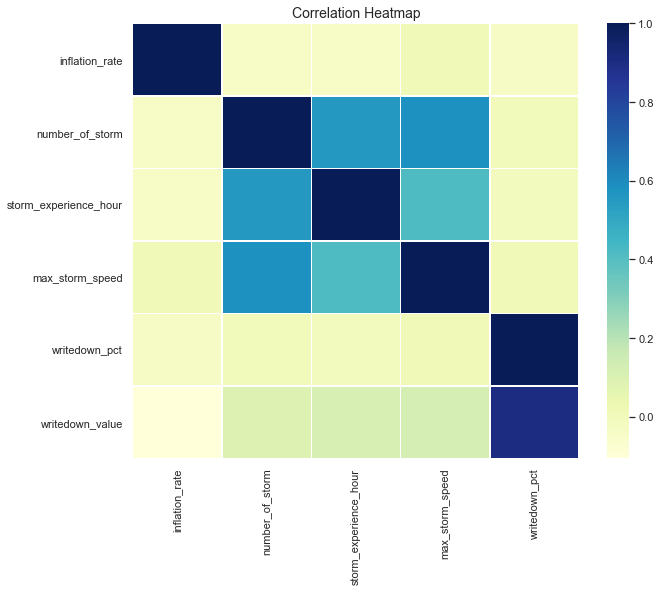

In [41]:
df_corr=df_company_asset_down_model[[ 'inflation_rate','number_of_storm', 'storm_experience_hour', 'max_storm_speed','writedown_pct','writedown_value']].corr()

display(df_corr)

plt.figure(figsize=(10,8))

sns.heatmap(df_corr.iloc[:30,:-1], cmap="YlGnBu",linewidths=.5)
plt.title("Correlation Heatmap",fontsize=14)

In [42]:
import statsmodels.api as sm

x=sm.add_constant(df_company_asset_down_model[['inflation_rate','number_of_storm', 'storm_experience_hour', 'max_storm_speed']].fillna(0))
y=df_company_asset_down_model['writedown_value']
regr=sm.OLS(y,x)
res=regr.fit()

In [43]:
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Ordinary least squares
=====================================================================
Model:               OLS               Adj. R-squared:      0.027    
Dependent Variable:  writedown_value   AIC:                 4828.1388
Date:                2021-12-07 10:29  BIC:                 4852.6222
No. Observations:    989               Log-Likelihood:      -2409.1  
Df Model:            4                 F-statistic:         7.954    
Df Residuals:        984               Prob (F-statistic):  2.60e-06 
R-squared:           0.031             Scale:               7.6823   
---------------------------------------------------------------------
                       Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
---------------------------------------------------------------------
const                  7.9946   0.2517 31.7607 0.0000  7.5006  8.4885
inflation_rate        -0.3173   0.0955 -3.3228 0.0009 -0.5047 -0.1299
number_of_storm       -0.0156   0.0646 -0.2417 0.8090 -0.1423  0.1111
storm_experience_hour  0.0055   0.0030  1.8234 0.0685 -0.0004  0.0114
max_storm_speed        0.0086   0.0032  2.6953 0.0072  0.0023  0.0149
---------------------------------------------------------------------
Omnibus:                56.216        Durbin-Watson:           1.887 
Prob(Omnibus):          0.000         Jarque-Bera (JB):        64.847
Skew:                   -0.626        Prob(JB):                0.000 
Kurtosis:               3.085         Condition No.:           187   
=====================================================================

"""